In [8]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy

data = pd.read_csv('features_Z140Hep.csv')
data


,uid,NarrativeLE,NarrativeCME,LE_CircumstancesOtherText,CME_CircumstancesOtherText,MentalHealthProblem,DepressedMood,MentalIllnessTreatmentCurrnt,HistoryMentalIllnessTreatmnt,SuicideAttemptHistory,...,HealthProblemPainUnkDuration,LE_HealthProblemTypeDescription,CME_HealthProblemTypeDescription,HouseholdSubstanceAbuse,AbusedAsChild,PriorCPSReport,VictimKnownToAuthorities,InterpersonalViolencePerp,InterpersonalViolenceVictim,TraumaticBrainInjuryHistory
0,aaaf,V (XX XX) shot himself in a motor vehicle.The ...,V (XX XX) shot himself in a motor vehicle.The ...,NaN,NaN,0,0,0,0,0,...,0,NaN,NaN,0,0,0,0,0,0,0
1,aaby,V was XXXX. V was found in the basement of his...,V was XXXX. V was found in the basement of hi...,NaN,NaN,0,0,0,0,0,...,0,NaN,NaN,0,0,0,0,0,0,0
2,aacl,V was XXXX. V was found in his residence unres...,V was XXXX. V was found in his residence suffe...,NaN,Marijuana,0,0,0,0,0,...,0,NaN,NaN,0,0,0,0,0,0,0
3,aacn,"The victim, a XX XX who had recently returned ...",On the day of the fatal event in the early mor...,NaN,NaN,0,1,0,0,0,...,0,NaN,NaN,0,0,0,0,0,0,0
4,aadb,XX XX V found deceased at home by his grandpar...,XX XX V found deceased at home by his grandpar...,NaN,NaN,0,0,0,0,0,...,0,NaN,NaN,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,fhri,The victim was a XX XX who was discovered at h...,The victim was a XX XX who was discovered at h...,NaN,NaN,1,0,1,1,1,...,0,NaN,NaN,0,0,0,0,0,0,0
3996,fhrn,The V is a XX XX. The cause of death is acute ...,The V is a XX XX. The Cause of death is Acute ...,NaN,NaN,1,0,0,1,1,...,0,NaN,NaN,0,0,0,0,0,0,0
3997,fhsx,V was a XX XX. V was found deceased in his bed...,"V was a XX XX. On the day of the incident, V r...",NaN,NaN,0,0,0,0,1,...,0,NaN,NaN,0,0,0,0,0,0,0
3998,fhtq,"At 0100 hours, local police received a call of...","At approximately 0041 hours, officers responde...",NaN,NaN,0,0,0,0,0,...,0,NaN,NaN,0,0,0,0,0,0,0


In [9]:
# Выберем столбцы, которые содержат диагнозы
diagnosis_columns = [
    'LE_MentalHealthDiagnosis1', 
    'LE_MentalHealthDiagnosis2', 
    'LE_MentalHealthDiagnosisOther',
    'CME_MentalHealthDiagnosis1',
    'CME_MentalHealthDiagnosis2',
    'CME_MentalHealthDiagnosisOther'
]

# Применим One-Hot Encoding к выбранным столбцам
diagnosis_data = data[diagnosis_columns]

# Заполним пропуски пустыми строками, чтобы избежать ошибок при кодировании
diagnosis_data = diagnosis_data.fillna('Unknown')

# Применяем One-Hot Encoding
encoded_diagnosis_data = pd.get_dummies(diagnosis_data, prefix=diagnosis_columns)

# Объединим закодированные данные с исходным набором данных
data_with_encoded_diagnosis = pd.concat([data, encoded_diagnosis_data], axis=1)

# Удалим старые текстовые столбцы с диагнозами
data_with_encoded_diagnosis = data_with_encoded_diagnosis.drop(columns=diagnosis_columns)

# Покажем результат
data_with_encoded_diagnosis.head()

,uid,NarrativeLE,NarrativeCME,LE_CircumstancesOtherText,CME_CircumstancesOtherText,MentalHealthProblem,DepressedMood,MentalIllnessTreatmentCurrnt,HistoryMentalIllnessTreatmnt,SuicideAttemptHistory,...,CME_MentalHealthDiagnosisOther_Suicidal ideations,CME_MentalHealthDiagnosisOther_Suicidal ideations and drug induced psychosis,CME_MentalHealthDiagnosisOther_Suicide ideation,CME_MentalHealthDiagnosisOther_Suicide ideations,CME_MentalHealthDiagnosisOther_Tourette syndrome,CME_MentalHealthDiagnosisOther_Unknown,CME_MentalHealthDiagnosisOther_Unspecified behavioral problems,CME_MentalHealthDiagnosisOther_Unspecified mood disorder,CME_MentalHealthDiagnosisOther_Unspecified psychosis,CME_MentalHealthDiagnosisOther_Unstated mental health issues
0,aaaf,V (XX XX) shot himself in a motor vehicle.The ...,V (XX XX) shot himself in a motor vehicle.The ...,NaN,NaN,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
1,aaby,V was XXXX. V was found in the basement of his...,V was XXXX. V was found in the basement of hi...,NaN,NaN,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
2,aacl,V was XXXX. V was found in his residence unres...,V was XXXX. V was found in his residence suffe...,NaN,Marijuana,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
3,aacn,"The victim, a XX XX who had recently returned ...",On the day of the fatal event in the early mor...,NaN,NaN,0,1,0,0,0,...,False,False,False,False,False,True,False,False,False,False
4,aadb,XX XX V found deceased at home by his grandpar...,XX XX V found deceased at home by his grandpar...,NaN,NaN,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False


In [12]:
# Отфильтруем только числовые признаки для кластеризации
data = data_with_encoded_diagnosis.select_dtypes(exclude='object')
data

,MentalHealthProblem,DepressedMood,MentalIllnessTreatmentCurrnt,HistoryMentalIllnessTreatmnt,SuicideAttemptHistory,SuicideThoughtHistory,AlcoholProblem,SubstanceAbuseOther,OtherAddiction,HistorySelfHarm,...,CME_MentalHealthDiagnosisOther_Suicidal ideations,CME_MentalHealthDiagnosisOther_Suicidal ideations and drug induced psychosis,CME_MentalHealthDiagnosisOther_Suicide ideation,CME_MentalHealthDiagnosisOther_Suicide ideations,CME_MentalHealthDiagnosisOther_Tourette syndrome,CME_MentalHealthDiagnosisOther_Unknown,CME_MentalHealthDiagnosisOther_Unspecified behavioral problems,CME_MentalHealthDiagnosisOther_Unspecified mood disorder,CME_MentalHealthDiagnosisOther_Unspecified psychosis,CME_MentalHealthDiagnosisOther_Unstated mental health issues
0,0,0,0,0,0,1,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
2,0,0,0,0,0,1,0,1,0,0,...,False,False,False,False,False,True,False,False,False,False
3,0,1,0,0,0,1,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,0,1,1,1,0,1,0,0,1,...,False,False,False,False,False,False,False,False,False,False
3996,1,0,0,1,1,1,0,1,0,0,...,False,False,False,False,False,True,False,False,False,False
3997,0,0,0,0,1,1,0,1,0,0,...,False,False,False,False,False,True,False,False,False,False
3998,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False


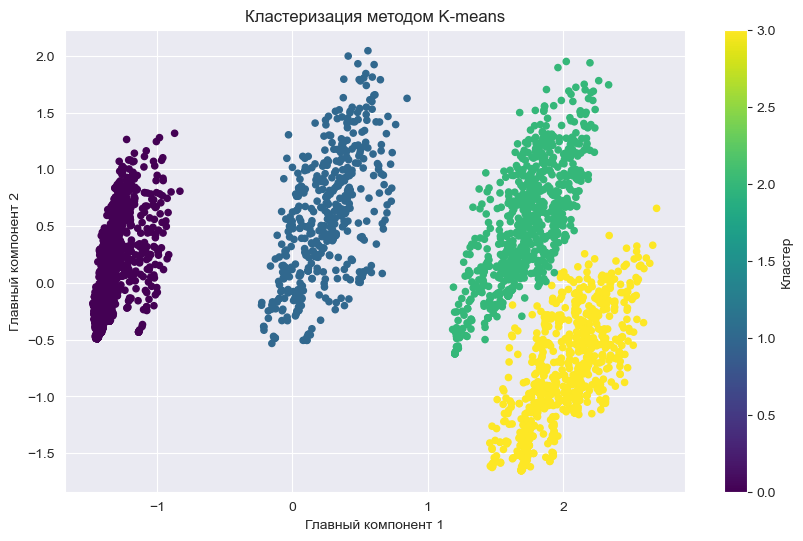

In [24]:
# Применим PCA для снижения размерности до 2D для визуализации
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)

# Кластеризация методом K-means
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)  # 4 кластера для примера
clusters = kmeans.fit_predict(data)

# Визуализация кластеров
plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis', s=20)
plt.colorbar(label='Кластер')
plt.title('Кластеризация методом K-means')
plt.xlabel('Главный компонент 1')
plt.ylabel('Главный компонент 2')
plt.grid(True)
plt.show()

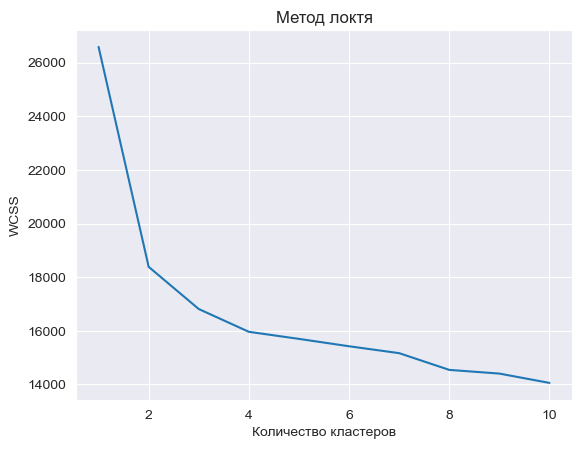

In [22]:
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 11):  # Проверяем от 1 до 10 кластеров
   kmeans = KMeans(n_clusters=i, random_state=42)
   kmeans.fit(data)
   wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.title('Метод локтя')
plt.grid(True)
plt.show()

In [26]:
# Вычисляем средние значения признаков для каждого кластера
cluster_means = data.groupby('Cluster').mean()

# Для каждого кластера находим признаки с наибольшими средними значениями
for cluster in cluster_means.index:
    print(f"\nКластер {cluster}:")
    # Отображаем топ-10 признаков с наибольшими значениями для данного кластера
    top_features = cluster_means.loc[cluster].sort_values(ascending=False).head(10)
    print(top_features)




Кластер 0:
CME_MentalHealthDiagnosis2_Unknown        1.000000
CME_MentalHealthDiagnosis1_Unknown        1.000000
LE_MentalHealthDiagnosis2_Unknown         1.000000
LE_MentalHealthDiagnosis1_Unknown         1.000000
CME_MentalHealthDiagnosisOther_Unknown    0.999521
LE_MentalHealthDiagnosisOther_Unknown     0.999042
SuicideNote                               0.309535
SuicideThoughtHistory                     0.293244
DepressedMood                             0.290848
IntimatePartnerProblem                    0.288452
Name: 0, dtype: float64

Кластер 1:
CME_MentalHealthDiagnosis2_Unknown                0.993450
MentalHealthProblem                               0.991266
CME_MentalHealthDiagnosisOther_Unknown            0.982533
LE_MentalHealthDiagnosisOther_Unknown             0.927948
LE_MentalHealthDiagnosis2_Unknown                 0.803493
CME_MentalHealthDiagnosis1_Unknown                0.796943
HistoryMentalIllnessTreatmnt                      0.792576
MentalIllnessTreatmentCurrnt 